## First, extract radioisotope data from Canberra PDFs

Run cell and follow instructions. Make sure to add the .csv ending to the output file name.

In [ ]:
import os
import pandas as pd
from PyPDF2 import PdfReader

def extract_pdf_values(folder_path, output_csv_path, parse_numbers=False):
    combined_data = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".PDF") or filename.endswith(".pdf"):
            file_path = os.path.join(folder_path, filename)
            file_name_without_extension = os.path.splitext(filename)[0]

            # Initialize variables to store isotopes' values
            pb210 = Bi214 = Pb214 = ptsrc_pb210 = None

            # Read in the PDF file
            try:
                reader = PdfReader(file_path)
                if len(reader.pages) < 3:
                    print(f"PDF file '{filename}' has less than 3 pages. Skipping.")
                    continue
                page = reader.pages[2]
                text = page.extract_text()
                lines = text.split('\n')

                # Check if the filename starts with 'PtSrc_'
                if filename.startswith("PtSrc_"):
                    # Only extract Pb-210 value for PtSrc files
                    for line in lines:
                        if 'Pb-210' in line:
                            ptsrc_pb210, PtSrc_Pb210error = line.split()[-2:]
                            break  # Exit the loop after finding Pb-210
                    # Store only Pb-210 values if found
                    if ptsrc_pb210 is not None and PtSrc_Pb210error is not None:
                        data = {'File': filename, 'Pb-210': float(ptsrc_pb210), 'Pb-210 error': float(PtSrc_Pb210error)}
                    else:
                        print(f"Pb-210 not found in '{filename}'. Skipping.")
                        continue
                else:
                    # Extract values for other files
                    for line in lines:
                        if 'Pb-210' in line:
                            pb210, pb210error = line.split()[-2:]
                        elif 'Bi-214' in line:
                            Bi214, Bi214error = line.split()[-2:]
                        elif 'Pb-214' in line:
                            Pb214, Pb214error = line.split()[-2:]

                    # Store values only if they were found
                    if pb210 is not None and pb210error is not None:
                        data = {
                            'File': filename,
                            'Pb-210': float(pb210),
                            'Pb-210 error': float(pb210error),
                            'Bi-214': float(Bi214) if Bi214 else None,
                            'Bi-214 error': float(Bi214error) if Bi214error else None,
                            'Pb-214': float(Pb214) if Pb214 else None,
                            'Pb-214 error': float(Pb214error) if Pb214error else None
                        }
                    else:
                        print(f"Pb-210 not found in '{filename}'. Skipping.")
                        continue

                combined_data.append(data)
            except Exception as e:
                print(f"Error processing PDF file '{filename}': {e}")

    # Create a DataFrame
    combined_df = pd.DataFrame(combined_data)

    # Extract the numeric part before the hyphen ('-') for sorting
    def extract_numeric_prefix(file_name):
        try:
            # Split the file name based on the underscore and hyphen and take the numeric part
            prefix = file_name.split('_')[-1].split('-')[0]
            return int(prefix)  # Convert the prefix to an integer
        except ValueError:
            return float('nan')  # Return NaN if the prefix is not numeric

    # Apply sorting based on the extracted numeric part
    combined_df['File_order'] = combined_df['File'].apply(extract_numeric_prefix)
    
    # Sort by the numeric part extracted
    combined_df = combined_df.sort_values(by='File_order')

    # Remove the 'File_order' column before saving
    combined_df = combined_df.drop(columns=['File_order'])

    # Optional: If you want to parse numbers into floats (e.g., for columns with values)
    if parse_numbers:
        combined_df[['Pb-210', 'Bi-214', 'Pb-214']] = combined_df[['Pb-210', 'Bi-214', 'Pb-214']].apply(lambda x: x.str.strip().astype(float))

    combined_df.to_csv(output_csv_path, index=False)

# Example usage:
folder_path = input("Enter the folder path: ")  # Ask for folder path
output_csv_path = input("Enter the output CSV file path: ")  # Ask for the output file path
extract_pdf_values(folder_path, output_csv_path)


# Open the output .csv file

Check to make sure all radioisotope data translated correctly. 

# Create two new columns and add data accordingly
- ptsrc_pb210,
- ptsrc_pb210 error


# Next, make sure your .csv files are correctly labeled for the age model calculations. 

Sample weights should have the following headings: 
- Core, Top of interval (cm),
- Center point of interval,
- Base of interval (cm),
- sediment weight (g) 

Radioisotope data should have the following headings
- File,
- Pb-210,
- Pb-210 error,
- Bi-214,
- Bi-214 error,
- Pb-214,
- Pb-214 error,
- ptsrc_pb210,
- ptsrc_pb210 error

Replace '/path.csv' and 'output_with_ages.csv' accordingly


In [2]:
import pandas as pd
import numpy as np
import re

# Prompt user for file paths and output file name
csv1_path = input("Enter the path to the sample weight CSV file (e.g., /path/weights.csv): ")
csv2_path = input("Enter the path to the Canberra data CSV file (e.g., /path/canberra.csv): ")
output_file_name = input("Enter the name for the output CSV file (e.g., output_with_ages.csv): ")

# Load the CSV files
csv1 = pd.read_csv(csv1_path)
csv2 = pd.read_csv(csv2_path)

# Extract 'Center point of interval' from .csv 2 based on the median of the last two digits in 'File'
csv2['Center point of interval'] = csv2['File'].apply(
    lambda x: np.median([int(num) for num in re.findall(r'\d+', x.split('_')[-1])])
)

# Merge CSV files based on 'Center point of interval'
data = pd.merge(csv1, csv2, on='Center point of interval', how='left')  # Merge using the new 'Center point of interval'

# Now proceed with the calculations based on your updated requirements

# Extract the 'year of core' as input
year_of_core = int(input("Enter the year of core (e.g., 2023): "))

# Calculate columns
data['Pb-210 activity (Bq/g)'] = data['Pb-210']/data['sediment weight (g)']
data['Pb-210 correction factor'] = data['ptsrc_pb210'] / 151031.56  # Correction factor for Pb-210
data['Self absorb. Corrected Pb-210 activity (Bq/g)'] = data['Pb-210 activity (Bq/g)'] / data['Pb-210 correction factor'] # Calculate Self absorb. Corrected Pb-210 activity (Bq/g)
data['Bi-214 activity (Bq/g)'] = data['Bi-214'] / data['sediment weight (g)']
data['Pb-214 activity (Bq/g)'] = data['Pb-214'] / data['sediment weight (g)']

# Averaged supported activity of Bi-214 and Pb-214
data['Averaged supported activity of Bi-214 and Pb-214 (Bq/g)'] = (
    data['Bi-214 activity (Bq/g)'] + data['Pb-214 activity (Bq/g)']
) / 2

# Calculate background activity uncertainty (Bq/g)
data['Background activity uncertainty (Bq/g)'] = (
    (data['Bi-214 error'] + data['Pb-214 error']) / 2
) / data['sediment weight (g)']


# Calculate Excess Pb-210 (Bq/g)
data['Excess Pb-210 (Bq/g)'] = data['Self absorb. Corrected Pb-210 activity (Bq/g)'] - data['Averaged supported activity of Bi-214 and Pb-214 (Bq/g)']

# Calculate surface activity (value of first interval's 'Excess Pb-210 (Bq/g)')
data['Surface activity'] = data['Excess Pb-210 (Bq/g)'].iloc[0]

# Calculate Age bp
data['Age bp'] = (1 / 0.03114) * np.log(data['Surface activity'] / data['Excess Pb-210 (Bq/g)'])

# Calculate 'calendar years pre year of core'
data['calendar years pre year of core'] = year_of_core - data['Age bp']

# Save the final DataFrame to a new CSV file
data.to_csv(output_file_name, index=False)  # Save as user-defined file name

print(f"Calculations completed, data exported to '{output_file_name}'")


Enter the path to the sample weight CSV file (e.g., /path/weights.csv): /Users/alehrmann/Documents/Research_files/West_Antarctica/Amundsen_Sea/NBP2002KC72_weights.csv
Enter the path to the Canberra data CSV file (e.g., /path/canberra.csv): /Users/alehrmann/Documents/Research_files/West_Antarctica/Amundsen_Sea/NBP2002 KC72.csv
Enter the name for the output CSV file (e.g., output_with_ages.csv): AgeModel_output_NBP2002KC72
Enter the year of core (e.g., 2023): 2020
Calculations completed, data exported to 'AgeModel_output_NBP2002KC72'


# Check the output data. Does it make sense?

# Now plot it!

Enter the core name for the title: NBP2002 KC72
Enter the depths (comma-separated) where 'calendar years pre year of core' should be labeled (or type 'all' to label all intervals): all


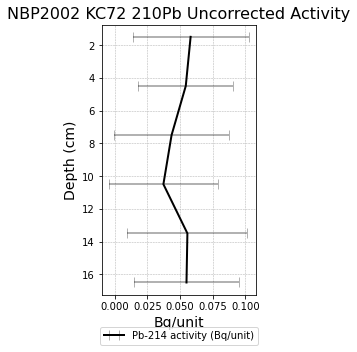

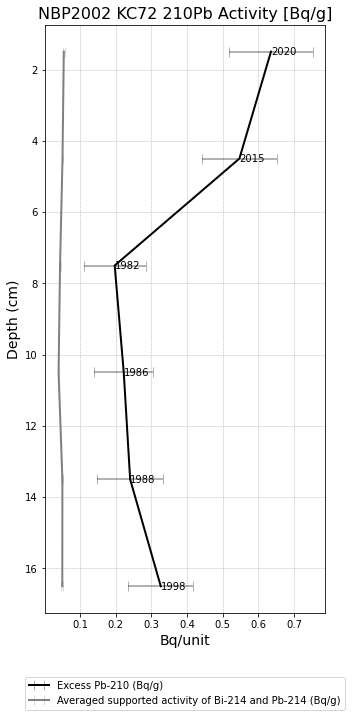

In [7]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Get the core name from user input
core_name = input("Enter the core name for the title: ")

# Ask user for depths to label "calendar years pre year of core"
depths_to_label_input = input("Enter the depths (comma-separated) where 'calendar years pre year of core' should be labeled (or type 'all' to label all intervals): ")

# If the user types 'all', label all intervals
if depths_to_label_input.lower() == 'all':
    depths_to_label = data['Center point of interval'].tolist()  # Use all depth intervals
else:
    # Otherwise, parse the comma-separated depths
    depths_to_label = [float(depth.strip()) for depth in depths_to_label_input.split(",")]

# Define colors for the series and lighter shades for error bars
excess_pb210_color = 'black'
excess_pb210_error_color = mcolors.to_rgba(excess_pb210_color, alpha=0.3)  # Lighter black with transparency
supported_activity_color = 'grey'
supported_activity_error_color = mcolors.to_rgba(supported_activity_color, alpha=0.3)  # Lighter grey with transparency

# Plot 1: Dynamic Core 210Pb Uncorrected Activity
plt.figure(figsize=(3, 5))
plt.errorbar(data['Pb-214 activity (Bq/g)'], data['Center point of interval'], 
             xerr=data['Pb-214 error'], fmt='-', color=excess_pb210_color, label='Pb-214 activity (Bq/unit)', 
             capsize=5, linewidth=2, ecolor=excess_pb210_error_color)  # Lightened error color
plt.title(f"{core_name} 210Pb Uncorrected Activity", fontsize=16)
plt.xlabel("Bq/unit", fontsize=14)
plt.ylabel("Depth (cm)", fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to show depth from surface
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)  # Move legend below plot
plt.tight_layout()
plt.savefig('core_210Pb_uncorrected_activity.pdf', format='pdf', bbox_inches='tight')  # Save as PDF
plt.show()

# Plot 2: Dynamic Core 210Pb Activity with error bars
plt.figure(figsize=(5, 10))

# Series 1: Excess Pb-210 (Bq/g) with error bars
plt.errorbar(data['Excess Pb-210 (Bq/g)'], data['Center point of interval'], 
             xerr=data['Pb-210 error'], fmt='-', color=excess_pb210_color, label='Excess Pb-210 (Bq/g)', 
             capsize=5, linewidth=2, ecolor=excess_pb210_error_color)  # Lightened error color

# Series 2: Averaged supported activity of Bi-214 and Pb-214 (Bq/g) with error bars
plt.errorbar(data['Averaged supported activity of Bi-214 and Pb-214 (Bq/g)'], data['Center point of interval'], 
             xerr=data['Background activity uncertainty (Bq/g)'], fmt='-', color=supported_activity_color, 
             label='Averaged supported activity of Bi-214 and Pb-214 (Bq/g)', capsize=5, linewidth=2, 
             ecolor=supported_activity_error_color)  # Lightened error color

# Label the selected depths with "calendar years pre year of core" from the data column
for i, depth in enumerate(data['Center point of interval']):
    if depth in depths_to_label:
        # Get the corresponding 'calendar years pre year of core' value and convert to an integer for a clean label
        year_value = data['calendar years pre year of core'].iloc[i]
        
        # Check if the value is NaN (and skip it if it is)
        if not pd.isna(year_value):
            year = int(year_value)
            # Place the label next to Series 1 (Excess Pb-210) values at the specified depth
            plt.text(data['Excess Pb-210 (Bq/g)'].iloc[i], depth, 
                     f'{year}', fontsize=10, color='black', verticalalignment='center')

plt.title(f"{core_name} 210Pb Activity [Bq/g]", fontsize=16)
plt.xlabel("Bq/unit", fontsize=14)
plt.ylabel("Depth (cm)", fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to show depth from surface
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)  # Move legend below plot
plt.tight_layout()
plt.savefig('core_210Pb_activity_with_error_bars.pdf', format='pdf', bbox_inches='tight')  # Save as PDF
plt.show()
